In [1]:
%matplotlib inline  
import matplotlib.pyplot as plt
import tensorflow as tf 
from keras.models import Model
from tensorflow.keras import datasets, layers, models
from keras.layers import Conv2D, Input, multiply, UpSampling2D, Concatenate
from keras.applications.resnet import ResNet101,preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.applications.resnet import ResNet101


In [2]:
!wget https://wallpapercave.com/wp/qTcYPPc.jpg

--2021-11-26 14:27:14--  https://wallpapercave.com/wp/qTcYPPc.jpg
Resolving wallpapercave.com (wallpapercave.com)... 172.67.20.199, 104.22.60.71, 104.22.61.71, ...
Connecting to wallpapercave.com (wallpapercave.com)|172.67.20.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 304341 (297K) [image/jpeg]
Saving to: ‘qTcYPPc.jpg’

qTcYPPc.jpg         100%[===================>] 297.21K  --.-KB/s    in 0.09s   

2021-11-26 14:27:14 (3.36 MB/s) - ‘qTcYPPc.jpg’ saved [304341/304341]



In [3]:
!mv qTcYPPc.jpg dog.jpg

In [4]:
image = load_img('dog.jpg', target_size=(224, 224))

In [5]:
image = img_to_array(image)
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# prepare the image for the VGG model
image = preprocess_input(image)

In [6]:
inputs = Input(shape=(224, 224, 3))

In [7]:
resnet_model = ResNet101(weights='imagenet',input_tensor=inputs, include_top=False)

171458560/171446536 [==============================] - 2s 0us/step


In [8]:
#resnet_model.summary()

In [9]:
def conv_bn_relu(input, filters, kernel_size=(3, 3), strides=(2, 2), padding='same'):
  x = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, use_bias=False)(input) 
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  return x

## spatial path

In [10]:
#extracts feature maps that are 1/8 of the original image
def spatial_path(input):
  x = conv_bn_relu(input, 64)
  x = conv_bn_relu(x, 128)
  x = conv_bn_relu(x, 256)
  return x


## context path

In [11]:
def attention_refinement_module(out_channels, input):
  x = layers.GlobalAveragePooling2D(keepdims=True)(input)

  x = layers.Conv2D(filters=out_channels, kernel_size=(1, 1), strides=(1, 1))(x)  

  x = layers.BatchNormalization()(x)
  x = layers.Activation('sigmoid')(x)
  
  x = layers.Multiply()([input, x])

  return x

In [12]:
def feature_fusion_module(num_classes, input1, input2):
  x = layers.Concatenate(axis=-1)([input1,input2])

  feature = conv_bn_relu(x, num_classes, 3, 1)

  x = tf.keras.layers.GlobalAveragePooling2D(keepdims=True)(feature)

  x = conv_bn_relu(x, num_classes, 1, 2)
  x = layers.ReLU()(x)

  x = conv_bn_relu(x, num_classes, 1, 2)
  x = sigmoid(x)

  x = layers.Multiply()([feature, x])

  x = layers.Add()([feature, x]) 

  return x  


In [13]:
def context_path(input):
  features_list = [layer.output for layer in resnet_model.layers]
  activations_model = tf.keras.Model(inputs=resnet_model.input, outputs=features_list)
  activations = activations_model.predict(image)

  layer_names = []
  for layer in resnet_model.layers:
      layer_names.append(layer.name)
  for i, (layer_name, layer_activation) in enumerate(zip(layer_names, activations)):
      if(layer_name == 'conv4_block23_out'):
        feature16 = layer_activation
      if(layer_name == 'conv5_block3_out'):
        feature32 = layer_activation

  tail = tf.math.reduce_mean(feature32, axis=1, keepdims=True)
  tail = tf.math.reduce_mean(tail, axis=2, keepdims=True)

  return feature16, feature32, tail

In [14]:
sp = spatial_path(image)
print("sp.shape: ", sp.shape)

sp.shape:  (1, 28, 28, 256)


In [15]:
cx1, cx2, tail = context_path(image)

In [16]:
print("cx1.shape = ", cx1.shape)
print("cx2.shape = ", cx2.shape)
print("tail.shape = ", tail.shape)

cx1.shape =  (1, 14, 14, 1024)
cx2.shape =  (1, 7, 7, 2048)
tail.shape =  (1, 1, 1, 2048)


In [17]:
cx1 = attention_refinement_module(1024, cx1)
cx2 = attention_refinement_module(2048,cx2)


In [18]:
print("cx1.shape = ",cx1.shape)
print("cx2.shape = ",cx2.shape)

cx1.shape =  (1, 14, 14, 1024)
cx2.shape =  (1, 7, 7, 2048)


In [19]:
cx2 = multiply([tail,cx2])
print("cx2.shape = ", cx2.shape)

cx2.shape =  (1, 7, 7, 2048)


In [20]:
# upsampling
cx1 = UpSampling2D(size=2, data_format='channels_last', interpolation='bilinear')(cx1)
cx2 = UpSampling2D(size=4, data_format='channels_last', interpolation='bilinear')(cx2)
print(cx1.shape)
print(cx2.shape)



(1, 28, 28, 1024)
(1, 28, 28, 2048)


In [21]:
cx = Concatenate(axis=-1)([cx2, cx1])
print(cx.shape)

(1, 28, 28, 3072)


In [22]:
#result = feature_fusion_module(sp, cx)       
num_classes  =  12     
result = feature_fusion_module(num_classes, sp, cx)

In [23]:
print("result.shape = ",result.shape)

result.shape =  (1, 28, 28, 12)


In [24]:
# upsampling
result1 = UpSampling2D(size=8, data_format='channels_last', interpolation='bilinear')(result)
print("result1.shape = ", result1.shape)

result1.shape =  (1, 224, 224, 12)


In [25]:
#final convolution
result2 = layers.Conv2D(filters=num_classes, kernel_size=1, strides=1)(result1)
print("result2.shape = ", result2.shape)

result2.shape =  (1, 224, 224, 12)


In [26]:
result3 = tf.squeeze(result2)
print("result3.shape = ",result3.shape)

result3.shape =  (224, 224, 12)


In [27]:
result4 = tf.argmax(result3,axis=2)
print(result4.shape)

(224, 224)


The weights were random data and not trained yet, so the output picture is not a meaningful segmentation.

Just for data flow checking

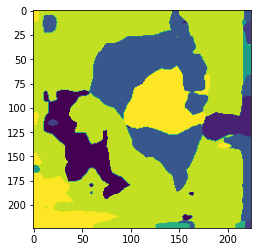

In [28]:
imgplot = plt.imshow(result4)
#the weights were not trained for segmentaion yet, so the picture is incorrect